# $^{241}\text{Am}$ $\alpha\text{-}\gamma$ Coincidence Example

In [44]:
import sauce
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

This setup includes two detectors: a silicon surface barrier (SSB) detector and cerium bromide (CeBr). In *sauce* we would define two detector instances to hold the hits for each detector.

In [45]:
run_data = sauce.Run("./241Am_p_a.parquet")
ssb = sauce.Detector("ssb").find_hits(run_data, module=2, channel=0)
cebr = sauce.Detector("cebr").find_hits(run_data, module=2, channel=1)

We first focus on the SSB analysis. We need to determine the singles count rate, $N_{\alpha}$. In order to do this we need to clean up the SSB spectrum and find the total number of counts. We need to see the data to do this step, since our spectrum is not energy calibrated.

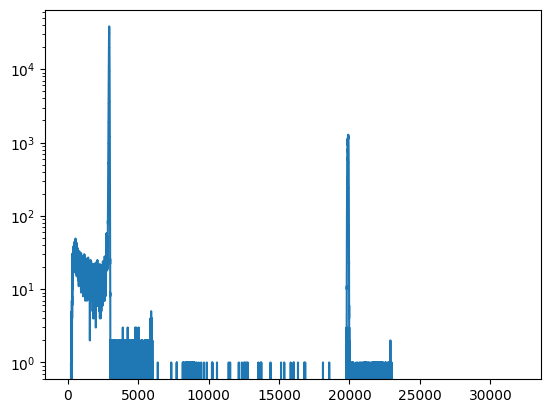

In [46]:
sauce.utils.step(*ssb.hist(0, 32000, 32000))
plt.yscale("log")

We can see that the main peak is at around channel 3000. The high energy events are overflow events, while the peak around channel 3000 is due to pulse pileup. We zoom in to finalize the gate.

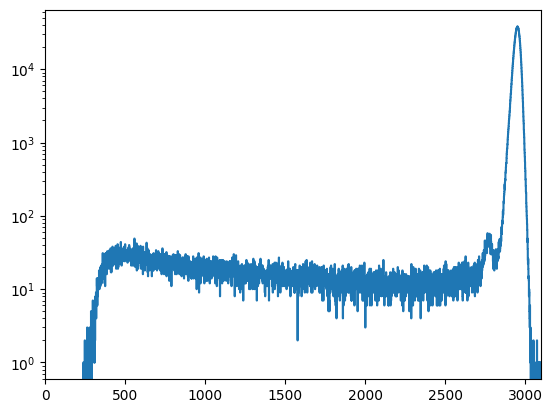

In [47]:
sauce.utils.step(*ssb.hist(0, 32000, 32000))
plt.xlim(0, 3100)
plt.yscale("log")

It looks like 3100 is a reasonable upper limit. In *sauce* we apply 1D cuts using the *apply_cut* method. Note that this is a destructive operation!

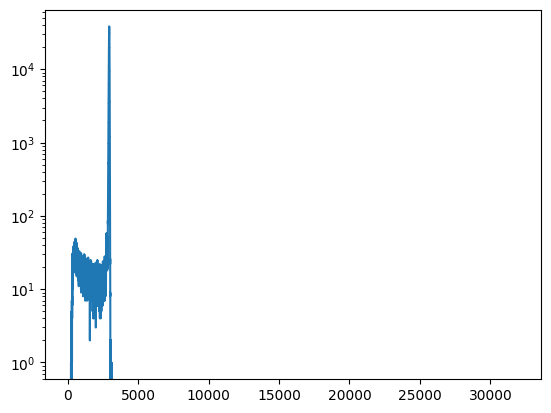

In [48]:
ssb.apply_cut((0, 3100))
sauce.utils.step(*ssb.hist(0, 32000, 32000))
plt.yscale("log")

In [49]:
c_ssb = ssb.counts()
print(c_ssb)

1719419


We now have the counts for the SSB, we still need the CeBr counts and the coincident counts.

(0.0, 5000.0)

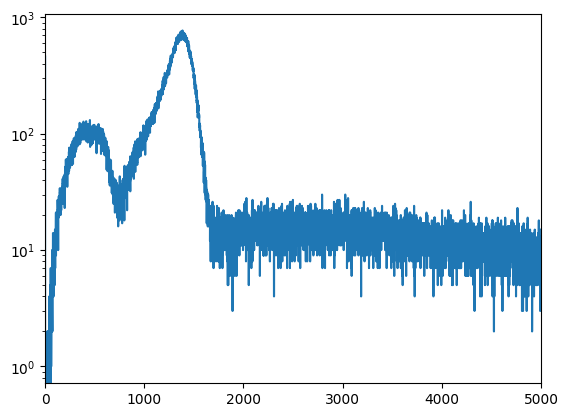

In [50]:
sauce.utils.step(*cebr.hist(0, 32000, 32000))
plt.yscale("log")
plt.xlim(0, 5000)

We are interseted in the 60 keV peak, which is around channel 1500. In order to get the correct counts we need an estimate of the background as well apply a gate. We will do this by selecting two regions, one around the peak region of the 60 keV line and the other around channel 2000 for a side band estimate of the background.

In [51]:
peak_region = [1200, 1600]
bkg_region = [2000, 2100]
peak_len_cebr = peak_region[1] - peak_region[0] 
bkg_len_cebr = bkg_region[1] - bkg_region[0]

bkg_cebr = (
    cebr.copy().apply_cut(bkg_region).counts()
)  # copy the data to avoid destructive operation.
bkg_per_bin = bkg_cebr / bkg_len_cebr
bkg_total = bkg_per_bin * peak_len_cebr

# now apply the cut to the peak region
cebr.apply_cut(peak_region)
c_cebr = cebr.counts() - bkg_total
print(c_cebr)

164766.0


Now we need to event build to get the coincident counts. We will use the SSB as the reference detector and have a $\pm 1000$ ns build window. 

In [52]:
eb = sauce.EventBuilder()
eb.add_timestamps(ssb)
eb.create_build_windows(-1000, 1000)

Now that we have the events, we still need to filter the hits in each detector. *sauce* provides the *Coincidence* class for this purpose. 

In [53]:
coin = sauce.Coincident(eb)
ssb_cebr = coin[
    ssb, cebr
]  # this creates a new Detector that will have the coincident events from both detectors.

We also need to do background subtraction for the coincidence spectrum, which we can do by using a side band estimate from the timing spectrum.

Text(0.5, 0, '$\\Delta t_{ssb - cebr}$ (ns)')

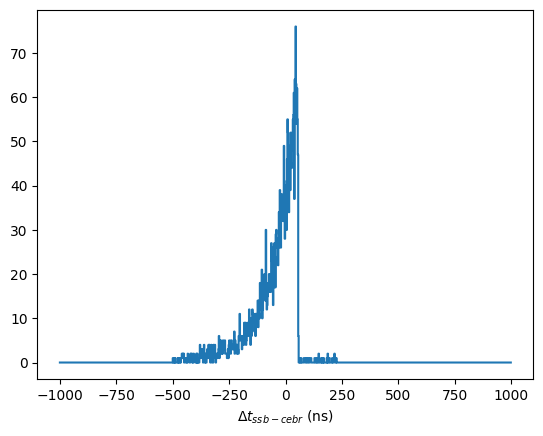

In [67]:
# time difference between the detectors.
ssb_cebr["dt"] = ssb_cebr["evt_ts_ssb"] - ssb_cebr["evt_ts_cebr"]
sauce.utils.step(*ssb_cebr.hist(-1000, 1000, 1000, axis="dt"))
plt.xlabel(r"$\Delta t_{ssb - cebr}$ (ns)")

We can see the evidence of the finite lifetime of the 60 keV state. We use 250 to 1000 ns for the background and a peak region of -500 to 250 ns.

In [55]:
peak_region = [-500, 250]
bkg_region = [250, 1000]
bkg_len_coin = bkg_region[1] - bkg_region[0]
peak_len_coin = peak_region[1] - peak_region[0]

bkg_coin = ssb_cebr.copy().apply_cut(bkg_region, axis="dt").counts()
bkg_per_bin = bkg_coin / bkg_len_coin
bkg_total = bkg_per_bin * peak_len_coin

# now apply the cut to the peak region
ssb_cebr.apply_cut(peak_region, axis="dt")
c_coin = ssb_cebr.counts() - bkg_total
print(c_coin)

3333.0


Finally, $N_{\alpha}$, $N_{\gamma}$, and $N_{\alpha\text{-}\gamma}$ are rates, which means we need the total run time. This should be closely approximated by the first and last hit in the run.

In [56]:
dt = (run_data.data["evt_ts"][-1] - run_data.data["evt_ts"][0]) / 1e9 # convert to seconds
print(dt)

1789.1253802425347


In [57]:
activity = ((c_cebr * c_ssb) / c_coin) / dt / 37000 # convert to uCi
print(rf"The activity is {activity:.3f} uCi")

The activity is 1.284 uCi


Statistical errors will be estimated assuming Possion statistics for all quantities. "_s" on a variable will indicate that is is a set of samples.

In [58]:
def draw_samples(val, samples=1000000):
    return norm.rvs(loc=val, scale=np.sqrt(val), size=samples)

In [66]:

c_ssb_s = draw_samples(c_ssb)
bkg_cebr_s =  peak_len_cebr * draw_samples(bkg_cebr)/bkg_len_cebr
c_cebr_s = draw_samples(cebr.counts()) - bkg_cebr_s
bkg_coin_s = peak_len_coin * draw_samples(bkg_coin)/bkg_len_coin
c_coin_s = draw_samples(ssb_cebr.counts()) - bkg_coin_s


activity_s = ((c_cebr_s * c_ssb_s) / c_coin_s) / dt / 37000 # convert to uCi
print(rf"The activity is {activity_s.mean():.3f} +/- {activity_s.std():.3f} uCi")

The activity is 1.284 +/- 0.023 uCi


The sames look fairly Gaussian, so we are done.

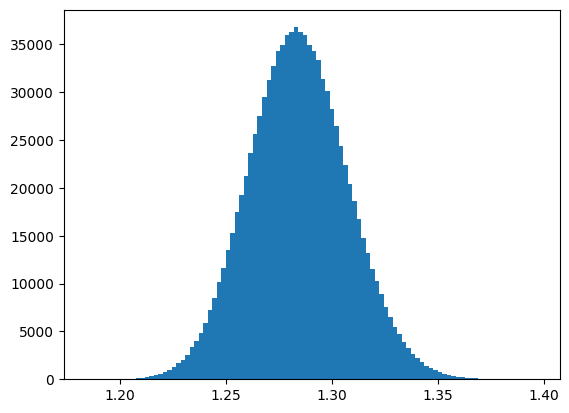

In [63]:
_ = plt.hist(activity_s, bins=100)

In [81]:
new = cebr.data.with_columns(
    (pl.col("adc") * 5.0).alias("e").thing().otherthing().thjing()
)